* Did some more EDA on univariate, bivariate and multivariate things. Noticed that in duration there are a few outliers. Duration is also fairly skewed.
* Started looking at outlier removal at the end of the notebook.

In [12]:
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import sys
sys.path.append('..') 
from src.data_preparation import compute_work_item_times, split_times
from src.evaluate import rmsle
from src.visualizations import plot_tree, plot_open_and_closed_tickets
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer

%matplotlib inline
sns.set_palette('Set2')

In [13]:
file_path = (r"C:\Users\ljeffery\Documents\Data Science Challenge\gdsc2_public.csv")
df = pd.read_csv(file_path, sep=';', parse_dates=['timestamp'])
df.from_phase.fillna('Start', inplace=True)  
df.to_phase.fillna('End', inplace=True)
df.components.fillna('', inplace=True)

In [14]:
df.head(10)

timestamp  work_item work_type work_priority    domain  platform  \
0 2015-01-02 14:39:14  WI_000001  WT_00001      WP_00003  BD_00001  PL_00001   
1 2015-01-02 15:04:20  WI_000002  WT_00002      WP_00004  BD_00002  PL_00002   
2 2015-01-02 15:28:22  WI_000003  WT_00002      WP_00004  BD_00002  PL_00002   
3 2015-01-02 15:33:54  WI_000004  WT_00002      WP_00004  BD_00002  PL_00002   
4 2015-01-02 16:32:11  WI_000005  WT_00002      WP_00003  BD_00003  PL_00003   
5 2015-01-02 16:56:27  WI_000006  WT_00002      WP_00003  BD_00003  PL_00003   
6 2015-01-03 14:33:10  WI_000007  WT_00002      WP_00003  BD_00001  PL_00001   
7 2015-01-03 15:16:17  WI_000007  WT_00002      WP_00003  BD_00001  PL_00001   
8 2015-01-04 20:57:40  WI_000008  WT_00002      WP_00003  BD_00003  PL_00003   
9 2015-01-04 21:28:12  WI_000009  WT_00002      WP_00003  BD_00004  PL_00004   

          components from_phase to_phase from_resource to_resource  
0                         Start  Analyze           NaN    ER_00043  
1  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225  
2  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225  
3  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225  
4           CO_00113      Start  Analyze           NaN    ER_00206  
5           CO_00113      Start  Analyze           NaN    ER_00206  
6                         Start  Analyze           NaN    ER_00054  
7                       Analyze   Design      ER_00054    ER_00212  
8           CO_00113      Start  Analyze           NaN    ER_00206  
9                         Start  Analyze           NaN    ER_00261

In [15]:
df.describe()

timestamp  work_item work_type work_priority    domain  \
count                 71957      71957     71957         71957     71957   
unique                71487      11564         3             5        11   
top     2018-02-26 10:12:33  WI_006500  WT_00001      WP_00003  BD_00002   
freq                     10         34     27794         35667     15761   
first   2015-01-02 14:39:14        NaN       NaN           NaN       NaN   
last    2018-03-30 19:07:03        NaN       NaN           NaN       NaN   

        platform components from_phase to_phase from_resource to_resource  
count      71957      71957      71957    71957         60393       61435  
unique        19        316          9        9           273         275  
top     PL_00002               Analyze  Analyze      ER_00239    ER_00239  
freq       15761      22192      11936    12519          2995        3001  
first        NaN        NaN        NaN      NaN           NaN         NaN  
last         NaN        NaN        NaN      NaN           NaN         NaN

In [16]:
df['Date'], df['Time'] = df['timestamp'].dt.normalize(), df['timestamp'].dt.time

In [17]:
df.head(10)

timestamp  work_item work_type work_priority    domain  platform  \
0 2015-01-02 14:39:14  WI_000001  WT_00001      WP_00003  BD_00001  PL_00001   
1 2015-01-02 15:04:20  WI_000002  WT_00002      WP_00004  BD_00002  PL_00002   
2 2015-01-02 15:28:22  WI_000003  WT_00002      WP_00004  BD_00002  PL_00002   
3 2015-01-02 15:33:54  WI_000004  WT_00002      WP_00004  BD_00002  PL_00002   
4 2015-01-02 16:32:11  WI_000005  WT_00002      WP_00003  BD_00003  PL_00003   
5 2015-01-02 16:56:27  WI_000006  WT_00002      WP_00003  BD_00003  PL_00003   
6 2015-01-03 14:33:10  WI_000007  WT_00002      WP_00003  BD_00001  PL_00001   
7 2015-01-03 15:16:17  WI_000007  WT_00002      WP_00003  BD_00001  PL_00001   
8 2015-01-04 20:57:40  WI_000008  WT_00002      WP_00003  BD_00003  PL_00003   
9 2015-01-04 21:28:12  WI_000009  WT_00002      WP_00003  BD_00004  PL_00004   

          components from_phase to_phase from_resource to_resource       Date  \
0                         Start  Analyze           NaN    ER_00043 2015-01-02   
1  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225 2015-01-02   
2  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225 2015-01-02   
3  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225 2015-01-02   
4           CO_00113      Start  Analyze           NaN    ER_00206 2015-01-02   
5           CO_00113      Start  Analyze           NaN    ER_00206 2015-01-02   
6                         Start  Analyze           NaN    ER_00054 2015-01-03   
7                       Analyze   Design      ER_00054    ER_00212 2015-01-03   
8           CO_00113      Start  Analyze           NaN    ER_00206 2015-01-04   
9                         Start  Analyze           NaN    ER_00261 2015-01-04   

       Time  
0  14:39:14  
1  15:04:20  
2  15:28:22  
3  15:33:54  
4  16:32:11  
5  16:56:27  
6  14:33:10  
7  15:16:17  
8  20:57:40  
9  21:28:12

In [18]:
date_count= pd.DataFrame(df.groupby('Date')['work_item'].count())
date_count.rename(columns ={"work_item": "work_item_count"}, inplace = True)

date_df = pd.merge(df, date_count, how = 'inner', on=['Date'])
# date_df = df.join(date_count, how = 'inner')

date_df.head()

timestamp  work_item work_type work_priority    domain  platform  \
0 2015-01-02 14:39:14  WI_000001  WT_00001      WP_00003  BD_00001  PL_00001   
1 2015-01-02 15:04:20  WI_000002  WT_00002      WP_00004  BD_00002  PL_00002   
2 2015-01-02 15:28:22  WI_000003  WT_00002      WP_00004  BD_00002  PL_00002   
3 2015-01-02 15:33:54  WI_000004  WT_00002      WP_00004  BD_00002  PL_00002   
4 2015-01-02 16:32:11  WI_000005  WT_00002      WP_00003  BD_00003  PL_00003   

          components from_phase to_phase from_resource to_resource       Date  \
0                         Start  Analyze           NaN    ER_00043 2015-01-02   
1  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225 2015-01-02   
2  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225 2015-01-02   
3  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225 2015-01-02   
4           CO_00113      Start  Analyze           NaN    ER_00206 2015-01-02   

       Time  work_item_count  
0  14:39:14                6  
1  15:04:20                6  
2  15:28:22                6  
3  15:33:54                6  
4  16:32:11                6

In [26]:
date_df['Date'] = date_df['Date'].astype('str')

date_components.head()

timestamp  work_item work_type work_priority    domain  platform  \
0 2015-01-02 14:39:14  WI_000001  WT_00001      WP_00003  BD_00001  PL_00001   
1 2015-01-02 15:04:20  WI_000002  WT_00002      WP_00004  BD_00002  PL_00002   
2 2015-01-02 15:28:22  WI_000003  WT_00002      WP_00004  BD_00002  PL_00002   
3 2015-01-02 15:33:54  WI_000004  WT_00002      WP_00004  BD_00002  PL_00002   
4 2015-01-02 16:32:11  WI_000005  WT_00002      WP_00003  BD_00003  PL_00003   

          components from_phase from_resource to_resource  ...  0  1  2  3  4  \
0                         Start           NaN    ER_00043  ...  1  1  1  0  0   
1  CO_00037/CO_00071      Start           NaN    ER_00225  ...  1  1  1  0  0   
2  CO_00037/CO_00071      Start           NaN    ER_00225  ...  1  1  1  0  0   
3  CO_00037/CO_00071      Start           NaN    ER_00225  ...  1  1  1  0  0   
4           CO_00113      Start           NaN    ER_00206  ...  1  1  1  0  0   

   5  6  7  8  9  
0  1  0  0  0  0  
1  1  0  0  0  0  
2  1  0  0  0  0  
3  1  0  0  0  0  
4  1  0  0  0  0  

[5 rows x 24 columns]

In [19]:
# from_phase = pd.DataFrame(df.groupby('work_item')['from_phase'].apply(','.join))
to_phase = pd.DataFrame(df.groupby('work_item')['to_phase'].apply(','.join))
# from_resource = pd.DataFrame(df.groupby('work_item')['from_resource'].apply(','.join))
df['to_resource'] = df['to_resource'].astype('str')
to_resource = pd.DataFrame(df.groupby('work_item')['to_resource'].apply(','.join))

# to_phase['to_phase'] = to_phase['to_phase'].astype('str')




In [20]:
to_resource.head()

to_resource
work_item                                                   
WI_000001  ER_00043,ER_00149,ER_00149,ER_00043,ER_00149,E...
WI_000002                     ER_00225,ER_00225,ER_00225,nan
WI_000003  ER_00225,ER_00225,ER_00225,ER_00225,ER_00225,E...
WI_000004  ER_00225,ER_00239,ER_00239,ER_00239,ER_00239,E...
WI_000005  ER_00206,ER_00075,ER_00075,ER_00088,ER_00206,E...

In [21]:
# One hot encode the components
# to_resource['to_resource'] = to_resource['to_resource'].astype('str')
to_resource['to_resource'] = to_resource['to_resource'].str.split(',', -1, expand=False)

to_phase['to_phase'] = to_phase['to_phase'].str.split(',', -1, expand = False)

to_phase.head()

to_phase
work_item                                                   
WI_000001  [Analyze, Design, Analyze, Design, Analyze, De...
WI_000002                      [Analyze, Design, Build, End]
WI_000003  [Analyze, Design, Analyze, Design, Build, Test...
WI_000004  [Analyze, Design, Build, Test, Package, Accept...
WI_000005  [Analyze, Design, Build, Design, Build, Accept...

In [22]:
mlb = MultiLabelBinarizer()
resource_components = to_resource.join(pd.DataFrame(mlb.fit_transform(to_resource['to_resource']), 
                          columns=mlb.classes_, index=to_resource.index))
resource_components = resource_components.drop(['to_resource'], axis = 1)



mlb = MultiLabelBinarizer()
phase_components = to_phase.join(pd.DataFrame(mlb.fit_transform(to_phase['to_phase']), 
                          columns=mlb.classes_, index=to_phase.index))
phase_components = phase_components.drop(['to_phase'], axis = 1)

phase_components.head()

Accept  Analyze  Build  Clarify  Deploy  Design  End  Package  Test
work_item                                                                     
WI_000001       1        1      1        0       1       1    1        1     1
WI_000002       0        1      1        0       0       1    1        0     0
WI_000003       0        1      1        0       0       1    1        1     1
WI_000004       1        1      1        0       1       1    1        1     1
WI_000005       1        1      1        0       1       1    1        0     0

In [9]:
split_phases = to_phase['to_phase'].str.split(",", expand= True).add_prefix('pha_')
split_phases.replace(to_replace=[None], value='', inplace=True)
split_phases.drop_duplicates(inplace=True)

split_resources = to_resource['to_resource'].str.split(",", expand = True).add_prefix('res_')
split_resources.replace(to_replace = [None], value='', inplace=True)
split_resources.drop_duplicates(inplace=True)

In [25]:
split_phases.head()

NameError: name 'split_phases' is not defined

In [11]:
resource = to_resource.join(split_resources, how = 'inner')
resource.head()

to_resource     res_0  \
work_item                                                                
WI_000001  ER_00043,ER_00149,ER_00149,ER_00043,ER_00149,E...  ER_00043   
WI_000002                     ER_00225,ER_00225,ER_00225,nan  ER_00225   
WI_000003  ER_00225,ER_00225,ER_00225,ER_00225,ER_00225,E...  ER_00225   
WI_000004  ER_00225,ER_00239,ER_00239,ER_00239,ER_00239,E...  ER_00225   
WI_000005  ER_00206,ER_00075,ER_00075,ER_00088,ER_00206,E...  ER_00206   

              res_1     res_2     res_3     res_4     res_5     res_6  \
work_item                                                               
WI_000001  ER_00149  ER_00149  ER_00043  ER_00149  ER_00043  ER_00149   
WI_000002  ER_00225  ER_00225       nan                                 
WI_000003  ER_00225  ER_00225  ER_00225  ER_00225  ER_00225  ER_00225   
WI_000004  ER_00239  ER_00239  ER_00239  ER_00239  ER_00239  ER_00061   
WI_000005  ER_00075  ER_00075  ER_00088  ER_00206  ER_00088  ER_00206   

              res_7     res_8  ... res_24 res_25 res_26 res_27 res_28 res_29  \
work_item                      ...                                             
WI_000001  ER_00058  ER_00149  ...                                             
WI_000002                      ...                                             
WI_000003       nan            ...                                             
WI_000004       nan            ...                                             
WI_000005       nan            ...                                             

          res_30 res_31 res_32 res_33  
work_item                              
WI_000001                              
WI_000002                              
WI_000003                              
WI_000004                              
WI_000005                              

[5 rows x 35 columns]

In [12]:
# count_df.head()

In [13]:
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'percentage_missing': (df.isnull().sum()/len(df)*100)})
missing_data

total_missing  percentage_missing
timestamp                  0            0.000000
work_item                  0            0.000000
work_type                  0            0.000000
work_priority              0            0.000000
domain                     0            0.000000
platform                   0            0.000000
components                 0            0.000000
from_phase                 0            0.000000
to_phase                   0            0.000000
from_resource          11564           16.070709
to_resource                0            0.000000

In [23]:
# #Grouping the data by work_item
# work_items = (df.groupby([df['work_item'],df['work_type'], df['work_priority'],df['domain'],df['platform'], df['components'].fillna('tmp')])
#               .apply(','.join).reset_index().replace({'components':{'tmp':np.nan}}))
# work_items.head()
# items = work_items[['work_item', 'work_type', 'work_priority', 'domain','platform','components']]

# timestamps = df[['timestamp', 'work_item', 'priority_level']]
# by_item = pd.merge(timestamps, items, on = 'work_item')
# by_item.head(10).sort_values('work_item')

## pulling out the features that will be needed for the model. 
work_items = (df.groupby([df['work_item'],df['work_type'], df['work_priority'],df['domain'],df['platform'], df['components'].fillna('tmp')])
              .apply(','.join).reset_index().replace({'components':{'tmp':np.nan}}))
work_items.head()
# items = work_items[['work_item', 'work_type', 'work_priority', 'domain','platform','components']]
by_item = work_items[['work_item', 'work_type', 'work_priority', 'domain','platform','components']]
# timestamps = df[['timestamp', 'work_item']]
# by_item = pd.merge(timestamps, items, on = 'work_item')

by_item.head(10).sort_values('work_item')


work_item work_type work_priority    domain  platform         components
0  WI_000001  WT_00001      WP_00003  BD_00001  PL_00001                   
1  WI_000002  WT_00002      WP_00004  BD_00002  PL_00002  CO_00037/CO_00071
2  WI_000003  WT_00002      WP_00004  BD_00002  PL_00002  CO_00037/CO_00071
3  WI_000004  WT_00002      WP_00004  BD_00002  PL_00002  CO_00037/CO_00071
4  WI_000005  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113
5  WI_000006  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113
6  WI_000007  WT_00002      WP_00003  BD_00001  PL_00001                   
7  WI_000008  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113
8  WI_000009  WT_00002      WP_00003  BD_00004  PL_00004                   
9  WI_000010  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113

In [24]:
by_item['priority_level']= by_item['work_priority'].map({'WP_00001': 1, 'WP_00002':2, 'WP_00003':3,'WP_00004':4, 'WP_00005':5 })

In [25]:
# count_df[['count_resource', 'count_phase']] = df[['to_resource', 'to_phase']].groupby(df['work_item']).transform('count')
# by_item['resource_count'] = df['to_resource'].groupby(df['work_item'].count())
# by_item['phase_count'] = df['to_phase'].groupby(df['work_item'].count())

by_item['resource_count'] = df.groupby(['work_item'])['to_resource'].transform('count')
by_item['phase_count'] = df.groupby(['work_item'])['to_phase'].transform('count')
# df.groupby(['A','B']).B.agg('count').to_frame('c').reset_index()

#  df.groupby(["item", "color"])["id"].transform("count")


In [26]:
by_item.head(10)

work_item work_type work_priority    domain  platform         components  \
0  WI_000001  WT_00001      WP_00003  BD_00001  PL_00001                      
1  WI_000002  WT_00002      WP_00004  BD_00002  PL_00002  CO_00037/CO_00071   
2  WI_000003  WT_00002      WP_00004  BD_00002  PL_00002  CO_00037/CO_00071   
3  WI_000004  WT_00002      WP_00004  BD_00002  PL_00002  CO_00037/CO_00071   
4  WI_000005  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113   
5  WI_000006  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113   
6  WI_000007  WT_00002      WP_00003  BD_00001  PL_00001                      
7  WI_000008  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113   
8  WI_000009  WT_00002      WP_00003  BD_00004  PL_00004                      
9  WI_000010  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113   

   priority_level  resource_count  phase_count  
0               3              12           12  
1               4               4            4  
2               4               8            8  
3               4               8            8  
4               3               8            8  
5               3               8            8  
6               3               6            6  
7               3               6            6  
8               3               8            8  
9               3               2            2

In [27]:
def compute_work_item_times(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes a DataFrame with the ticket data and computes the start time, end time,  duration and the
    duration_in_hours.
    :param df: As described above
    :return: As described above
    """
    # We can't be sure that NAs were already renamed. Do it again just to be sure.
    df.from_phase.fillna('Start', inplace=True)
    df.to_phase.fillna('End', inplace=True)

    relevant_columns = ['work_item', 'timestamp']
    start_times = df[df.from_phase == 'Start'][relevant_columns]
    end_times = df[df.to_phase == 'End'][relevant_columns]
    times = pd.merge(start_times, end_times, on='work_item', how='left')
    times.rename(columns={'timestamp_x': 'start', 'timestamp_y': 'end'}, inplace=True)
    times['duration'] = times['end'] - times['start']
    times['duration_in_days'] = times['duration'].apply(lambda x: round(x.total_seconds() / (24*3600), 2))
    times['duration_in_hours'] = times['duration'].apply(lambda x: round(x.total_seconds() / (3600), 2))
    times['duration_in_minutes'] = times['duration'].apply(lambda x: round(x.total_seconds() / (60), 2))
    times['duration_in_seconds'] = times['duration'].apply(lambda x: round(x.total_seconds(), 2))
    return times

In [28]:
#computing the duration using the above function - edited version of the one they have given us
times = compute_work_item_times(df)
times = times.dropna(axis = 0)
times.head()

work_item               start                 end         duration  \
0  WI_000001 2015-01-02 14:39:14 2015-01-27 11:36:51 24 days 20:57:37   
1  WI_000002 2015-01-02 15:04:20 2015-01-14 09:46:37 11 days 18:42:17   
2  WI_000003 2015-01-02 15:28:22 2015-02-26 11:50:37 54 days 20:22:15   
3  WI_000004 2015-01-02 15:33:54 2015-01-28 09:11:05 25 days 17:37:11   
4  WI_000005 2015-01-02 16:32:11 2015-02-04 12:57:49 32 days 20:25:38   

   duration_in_days  duration_in_hours  duration_in_minutes  \
0             24.87             596.96             35817.62   
1             11.78             282.70             16962.28   
2             54.85            1316.37             78982.25   
3             25.73             617.62             37057.18   
4             32.85             788.43             47305.63   

   duration_in_seconds  
0            2149057.0  
1            1017737.0  
2            4738935.0  
3            2223431.0  
4            2838338.0

In [29]:
missing_data = pd.DataFrame({'total_missing': times.isnull().sum(), 'percentage_missing': (times.isnull().sum()/len(times)*100)})
missing_data

total_missing  percentage_missing
work_item                        0                 0.0
start                            0                 0.0
end                              0                 0.0
duration                         0                 0.0
duration_in_days                 0                 0.0
duration_in_hours                0                 0.0
duration_in_minutes              0                 0.0
duration_in_seconds              0                 0.0

In [30]:
#Combining the two dataframes together this gets us the durations combined with the grouped work_items
df2 = pd.merge(times, by_item, on = 'work_item')
df2 = df2.dropna(axis = 0)
df2.head(10)

work_item               start                 end         duration  \
0  WI_000001 2015-01-02 14:39:14 2015-01-27 11:36:51 24 days 20:57:37   
1  WI_000002 2015-01-02 15:04:20 2015-01-14 09:46:37 11 days 18:42:17   
2  WI_000003 2015-01-02 15:28:22 2015-02-26 11:50:37 54 days 20:22:15   
3  WI_000004 2015-01-02 15:33:54 2015-01-28 09:11:05 25 days 17:37:11   
4  WI_000005 2015-01-02 16:32:11 2015-02-04 12:57:49 32 days 20:25:38   
5  WI_000006 2015-01-02 16:56:27 2015-02-04 12:57:26 32 days 20:00:59   
6  WI_000007 2015-01-03 14:33:10 2015-01-19 10:23:31 15 days 19:50:21   
7  WI_000008 2015-01-04 20:57:40 2015-01-13 08:58:33  8 days 12:00:53   
8  WI_000009 2015-01-04 21:28:12 2015-01-06 14:52:25  1 days 17:24:13   
9  WI_000010 2015-01-05 08:56:47 2015-02-25 08:17:57 50 days 23:21:10   

   duration_in_days  duration_in_hours  duration_in_minutes  \
0             24.87             596.96             35817.62   
1             11.78             282.70             16962.28   
2             54.85            1316.37             78982.25   
3             25.73             617.62             37057.18   
4             32.85             788.43             47305.63   
5             32.83             788.02             47280.98   
6             15.83             379.84             22790.35   
7              8.50             204.01             12240.88   
8              1.73              41.40              2484.22   
9             50.97            1223.35             73401.17   

   duration_in_seconds work_type work_priority    domain  platform  \
0            2149057.0  WT_00001      WP_00003  BD_00001  PL_00001   
1            1017737.0  WT_00002      WP_00004  BD_00002  PL_00002   
2            4738935.0  WT_00002      WP_00004  BD_00002  PL_00002   
3            2223431.0  WT_00002      WP_00004  BD_00002  PL_00002   
4            2838338.0  WT_00002      WP_00003  BD_00003  PL_00003   
5            2836859.0  WT_00002      WP_00003  BD_00003  PL_00003   
6            1367421.0  WT_00002      WP_00003  BD_00001  PL_00001   
7             734453.0  WT_00002      WP_00003  BD_00003  PL_00003   
8             149053.0  WT_00002      WP_00003  BD_00004  PL_00004   
9            4404070.0  WT_00002      WP_00003  BD_00003  PL_00003   

          components  priority_level  resource_count  phase_count  
0                                  3              12           12  
1  CO_00037/CO_00071               4               4            4  
2  CO_00037/CO_00071               4               8            8  
3  CO_00037/CO_00071               4               8            8  
4           CO_00113               3               8            8  
5           CO_00113               3               8            8  
6                                  3               6            6  
7           CO_00113               3               6            6  
8                                  3               8            8  
9           CO_00113               3               2            2

In [31]:
cols = ['work_item', 'work_type', 'work_priority', 'domain','platform','components']
df2[cols].describe()

work_item work_type work_priority    domain  platform components
count       10522     10522         10522     10522     10522      10522
unique      10522         3             5        11        19        275
top     WI_009153  WT_00003      WP_00003  BD_00002  PL_00002           
freq            1      3892          5106      2376      2376       3325

In [33]:
cols_num =['duration_in_days']
df2[cols_num].describe()

duration_in_days
count      10522.000000
mean          56.729416
std          103.607514
min            0.000000
25%            4.890000
50%           19.020000
75%           62.210000
max         1112.920000

## Univariate Analysis

In [ ]:
plot1 = sns.countplot(data = df2, x = 'domain')
plt.xticks(rotation=90)
plt.show(plot1)

In [ ]:
ax = sns.countplot(data = df2, x = 'work_type')
plt.xticks(rotation=90)
plt.show(ax)

In [ ]:
ax = sns.countplot(data = df2, x = 'work_priority')
plt.xticks(rotation=90)
plt.show(ax)

In [ ]:
ax = sns.countplot(data = df2, x = 'platform')
plt.xticks(rotation=90)
plt.show(ax)

In [ ]:
# sns.countplot(data = df2, x = 'end')
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
sns.countplot(data = df2, x = 'priority_level')
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.distplot(times.duration_in_days, kde = False, color = 'b')
plt.figure(figsize=(30,30))

## Bivariate Analysis

In [ ]:
plt.plot_date(df2['timestamp'], df2['duration_in_hours'], xdate = True)
plt.xticks(rotation=90)

In [ ]:
# plt.figure(figsize=(10,10))
# sns.barplot( x=df2['work_item'], y=df2['duration_in_hours'])
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.stripplot( x=df2['work_type'], y=df2['duration_in_hours'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.stripplot( x=df2['work_priority'], y=df2['duration_in_hours'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.stripplot( x=df2['domain'], y=df2['duration_in_hours'] )
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.stripplot( x=df2['platform'], y=df2['duration_in_hours'] )
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x = 'domain', hue = 'work_type', data = df2)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x = 'platform', hue = 'work_type', data = df2)
plt.xticks(rotation=90)
plt.show()

In [15]:
plt.figure(figsize=(10,10))
sns.barplot(x = 'domain', y = 'duration_in_seconds', hue = 'work_priority', data = df2, ci=None)
plt.xticks(rotation=90)
plt.show()

NameError: name 'df2' is not defined

<Figure size 720x720 with 0 Axes>

In [16]:
plt.figure(figsize=(10,10))
sns.barplot(x = 'platform', y = 'duration_in_seconds', hue = 'work_priority', data = df2, ci=None)
plt.xticks(rotation=90)
plt.show()

NameError: name 'df2' is not defined

<Figure size 720x720 with 0 Axes>

In [17]:
plt.figure(figsize=(10,10))
sns.barplot(x = 'work_type', y = 'duration_in_seconds', hue = 'work_priority', data = df2, ci=None)
plt.xticks(rotation=90)
plt.show()

NameError: name 'df2' is not defined

<Figure size 720x720 with 0 Axes>

In [18]:
plt.figure(figsize=(10,10))
sns.barplot(x = 'domain', y = 'duration_in_seconds', hue = 'work_type', data = df2, ci=None)
plt.xticks(rotation=90)
plt.show()

NameError: name 'df2' is not defined

<Figure size 720x720 with 0 Axes>

In [34]:
## Removed outliers 3 standard deviations
outliers_removed = df2[np.abs(df2.duration_in_days-df2.duration_in_days.mean())<=(3*df2.duration_in_days.std())]

In [35]:
missing_data = pd.DataFrame({'total_missing': outliers_removed.isnull().sum(), 'percentage_missing': (outliers_removed.isnull().sum()/len(outliers_removed)*100)})
missing_data

total_missing  percentage_missing
work_item                        0                 0.0
start                            0                 0.0
end                              0                 0.0
duration                         0                 0.0
duration_in_days                 0                 0.0
duration_in_hours                0                 0.0
duration_in_minutes              0                 0.0
duration_in_seconds              0                 0.0
work_type                        0                 0.0
work_priority                    0                 0.0
domain                           0                 0.0
platform                         0                 0.0
components                       0                 0.0
priority_level                   0                 0.0
resource_count                   0                 0.0
phase_count                      0                 0.0

In [36]:
outliers_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10273 entries, 0 to 10521
Data columns (total 16 columns):
work_item              10273 non-null object
start                  10273 non-null datetime64[ns]
end                    10273 non-null datetime64[ns]
duration               10273 non-null timedelta64[ns]
duration_in_days       10273 non-null float64
duration_in_hours      10273 non-null float64
duration_in_minutes    10273 non-null float64
duration_in_seconds    10273 non-null float64
work_type              10273 non-null object
work_priority          10273 non-null object
domain                 10273 non-null object
platform               10273 non-null object
components             10273 non-null object
priority_level         10273 non-null int64
resource_count         10273 non-null int64
phase_count            10273 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(6), timedelta64[ns](1)
memory usage: 1.3+ MB


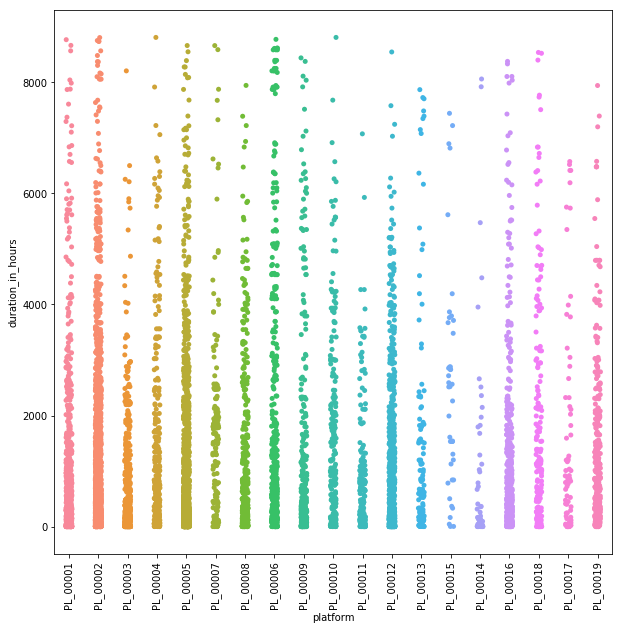

In [37]:
plt.figure(figsize=(10,10))
sns.stripplot( x=outliers_removed['platform'], y=outliers_removed['duration_in_hours'] )
plt.xticks(rotation=90)
plt.show()

<Figure size 2160x2160 with 0 Axes>

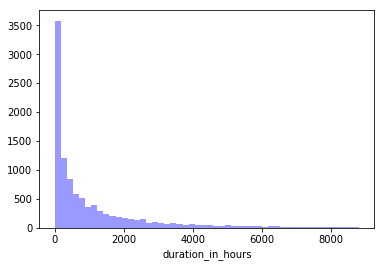

<Figure size 2160x2160 with 0 Axes>

In [96]:
sns.distplot(outliers_removed.duration_in_hours, kde = False, color = 'b')
plt.figure(figsize=(30,30))

In [97]:
df.work_priority.unique()



array(['WP_00003', 'WP_00004', 'WP_00002', 'WP_00001', 'WP_00005'],
      dtype=object)

In [ ]:
df.head()